In [1]:
!git clone https://github.com/sayakpaul/Adaptive-Gradient-Clipping

Cloning into 'Adaptive-Gradient-Clipping'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 65 (delta 30), reused 24 (delta 7), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [2]:
import sys
sys.path.append("Adaptive-Gradient-Clipping")

In [3]:
import tensorflow as tf
tf.random.set_seed(42)
print(tf.__version__)

2.5.0


In [4]:
try: # detect TPUs
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1


In [5]:
import agc
import dataloader
import models
import time
import utils

# 라이브러리 부르기
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
from glob import glob
import gc
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
import zipfile
from tqdm.auto import tqdm
import concurrent.futures
import functools

In [6]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [7]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

input_PATH = '/content/gdrive/MyDrive/dacon_camera/data/train_input_img/'
label_PATH = '/content/gdrive/MyDrive/dacon_camera/data/train_label_img/'
test_PATH = '/content/gdrive/MyDrive/dacon_camera/data/test_input_img/'

In [8]:
# 이미지 로드 함수
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  image = tf.cast(image, tf.float32)

  return image

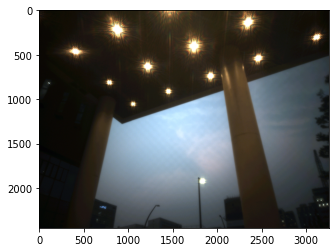

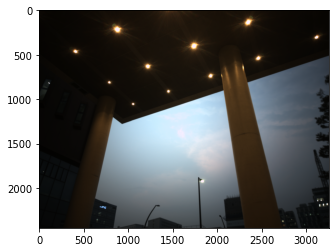

In [9]:
inp = load(input_PATH + 'train_input_10060.png')
re = load(label_PATH + 'train_label_10060.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [10]:
SAVE_TRAIN_INPUT_PATH = './data/train_input_img_'
SAVE_TRAIN_LABEL_PATH = './data/train_label_img_'

SAVE_VAL_INPUT_PATH = './data/val_input_img_'
SAVE_VAL_LABEL_PATH = './data/val_label_img_'

IMG_SIZE = 256

In [11]:
os.makedirs(f'{SAVE_TRAIN_INPUT_PATH}{IMG_SIZE}', exist_ok=True)
os.makedirs(f'{SAVE_TRAIN_LABEL_PATH}{IMG_SIZE}', exist_ok=True)
os.makedirs(f'{SAVE_VAL_INPUT_PATH}{IMG_SIZE}', exist_ok=True)
os.makedirs(f'{SAVE_VAL_LABEL_PATH}{IMG_SIZE}', exist_ok=True)

In [12]:
def cut_img(save_path, img_path):    
    img = cv2.imread(img_path)
    img_name = os.path.basename(img_path)
    num = 0
    for top in range(0, img.shape[0], STRIDE):
        for left in range(0, img.shape[1], STRIDE):
            piece = np.zeros([IMG_SIZE, IMG_SIZE, 3], np.uint8)
            temp = img[top:top+IMG_SIZE, left:left+IMG_SIZE, :]
            piece[:temp.shape[0], :temp.shape[1], :] = temp
            cv2.imwrite(f'{save_path}{IMG_SIZE}/{num}_{img_name}', piece)            
            # np.save(f'{save_path}{img_size}/{num}.npy', piece)                
            num+=1
    return

In [13]:
train_csv = pd.read_csv('/content/gdrive/MyDrive/dacon_camera/data/train.csv')
test_csv = pd.read_csv('/content/gdrive/MyDrive/dacon_camera/data/test.csv')

train_all_input_files = '/content/gdrive/MyDrive/dacon_camera/data/train_input_img/'+train_csv['input_img']
train_all_label_files = '/content/gdrive/MyDrive/dacon_camera/data/train_label_img/'+train_csv['label_img']
# 파일이름 + 경로

train_input_files = train_all_input_files[60:]
train_label_files = train_all_label_files[60:]
#테스트용

val_input_files = train_all_input_files[:60]
val_label_files = train_all_label_files[:60]
#검증용

In [14]:
STRIDE = 256

with concurrent.futures.ProcessPoolExecutor() as executor: # windows local 환경시 max_workers=os.cpu_count()//2
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_TRAIN_INPUT_PATH), train_input_files),             
        desc='train input image cut',
        total=len(train_input_files)
    ))
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_TRAIN_LABEL_PATH), train_label_files),             
        desc='train label image cut',
        total=len(train_label_files)
    ))
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_VAL_INPUT_PATH), val_input_files),             
        desc='val input image cut',
        total=len(val_input_files)
    ))
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_VAL_LABEL_PATH), val_label_files),             
        desc='val label image cut',
        total=len(val_label_files)
    ))

In [15]:
train_inp_files = glob(f'./data/train_input_img_256/*.png')
train_targ_files = glob(f'./data/train_label_img_256/*.png')

val_inp_files = glob(f'./data/val_input_img_256/*.png')
val_targ_files = glob(f'./data/val_label_img_256/*.png')

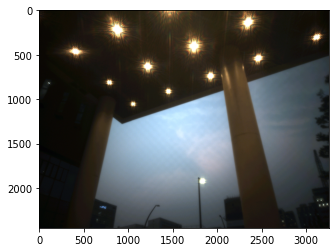

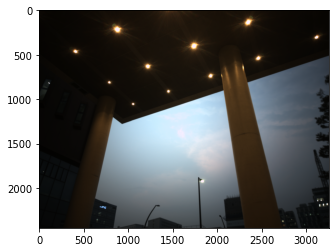

In [16]:
inp_256 = load('./data/train_input_img_256/0_train_input_10060.png')
re_256 = load('./data/train_label_img_256/0_train_label_10060.png')

plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [17]:
# 전처리 유틸 함수

def resize(image, height, width):
  image = tf.image.resize(image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return image

In [18]:
# normalizing the images to [-1, 1]

def normalize(image):
  image = (image / 127.5) - 1

  return image

In [19]:
# 통합 전처리 함수

def preprocess(image) :

    #resize
    image = resize(image, 256, 256)

    #augmentation 생략

    return image

In [20]:
# 데이터 불러오기

def load_image_train(image_file):
  image = load(image_file)
  image = preprocess(image)
  image = normalize(image)

  return image

def load_image_test(image_file):
  image = load(image_file)
  image = resize(image, IMG_HEIGHT, IMG_WIDTH)
  image = normalize(image)

  return image

In [21]:
train_input_dataset = tf.data.Dataset.list_files(SAVE_TRAIN_INPUT_PATH+'256/*.png')
train_input_dataset = train_input_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_input_dataset = train_input_dataset.shuffle(BUFFER_SIZE)
train_input_dataset = train_input_dataset.batch(BATCH_SIZE)

train_label_dataset = tf.data.Dataset.list_files(SAVE_TRAIN_LABEL_PATH+'256/*.png')
train_label_dataset = train_label_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_label_dataset = train_label_dataset.shuffle(BUFFER_SIZE)
train_label_dataset = train_label_dataset.batch(BATCH_SIZE)


val_input_dataset = tf.data.Dataset.list_files(SAVE_VAL_INPUT_PATH+'256/*.png')
val_input_dataset = val_input_dataset.map(load_image_test)
val_input_dataset = val_input_dataset.batch(BATCH_SIZE)

val_label_dataset = tf.data.Dataset.list_files(SAVE_VAL_LABEL_PATH+'256/*.png')
val_label_dataset = val_label_dataset.map(load_image_test)
val_label_dataset = val_label_dataset.batch(BATCH_SIZE)


train_input_dataset.element_spec, train_label_dataset.element_spec, val_input_dataset.element_spec, val_label_dataset.element_spec

(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None))

In [22]:
train_ds = tf.data.Dataset.zip((train_input_dataset, train_label_dataset))
val_ds = tf.data.Dataset.zip((val_input_dataset, val_label_dataset))

In [23]:
train_ds.element_spec, val_ds.element_spec

((TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None)))

In [24]:
class AGCModel(tf.keras.Model):
    def __init__(self, mini_vgg, clip_factor=0.01, eps=1e-3):
        super(AGCModel, self).__init__()
        self.mini_vgg = mini_vgg
        self.clip_factor = clip_factor
        self.eps = eps
    
    def train_step(self, data):
        images, labels = data

        with tf.GradientTape() as tape:
            predictions = self.mini_vgg(images)
            loss = self.compiled_loss(labels, predictions)
        trainable_params = self.mini_vgg.trainable_variables
        gradients = tape.gradient(loss, trainable_params)
        agc_gradients = agc.adaptive_clip_grad(trainable_params, gradients, 
                                               clip_factor=self.clip_factor, eps=self.eps)
        self.optimizer.apply_gradients(zip(agc_gradients, trainable_params))

        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        images, labels = data
        predictions = self.mini_vgg(images, training=False)
        loss = self.compiled_loss(labels, predictions)
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def save_weights(self, filepath):
        self.mini_vgg.save_weights(filepath=filepath)

    def call(self, inputs, *args, **kwargs):
        return self.mini_vgg(inputs)

In [25]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = tf.keras.layers.Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if activation == True:
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(blockInput)
    x = tf.keras.layers.BatchNormalization()(x)
    blockInput = tf.keras.layers.BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = tf.keras.layers.Add()([x, blockInput])
    return x

In [26]:
def ResUNet101V2(input_shape=(None, None, 3), dropout_rate=0.1, start_neurons = 16):
    backbone = tf.keras.applications.ResNet101V2(weights=weights, include_top=False, input_shape=input_shape)
    input_layer = backbone.input
    
    conv4 = backbone.layers[122].output
    conv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(dropout_rate)(pool4)
    
    convm = tf.keras.layers.Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = tf.keras.layers.LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = tf.keras.layers.concatenate([deconv4, conv4])
    uconv4 = tf.keras.layers.Dropout(dropout_rate)(uconv4)
    
    uconv4 = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[76].output
    uconv3 = tf.keras.layers.concatenate([deconv3, conv3])    
    uconv3 = tf.keras.layers.Dropout(dropout_rate)(uconv3)
    
    uconv3 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[30].output
    uconv2 = tf.keras.layers.concatenate([deconv2, conv2])
        
    uconv2 = tf.keras.layers.Dropout(0.1)(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[2].output
    uconv1 = tf.keras.layers.concatenate([deconv1, conv1])
    
    uconv1 = tf.keras.layers.Dropout(0.1)(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = tf.keras.layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = tf.keras.layers.Dropout(0.1)(uconv0)
    uconv0 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = tf.keras.layers.Dropout(dropout_rate/2)(uconv0)
    output_layer = tf.keras.layers.Conv2D(3, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = tf.keras.models.Model(input_layer, output_layer)

    return model

In [28]:
weights = 'imagenet'
with strategy.scope():
    model = AGCModel(ResUNet101V2())

model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [29]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5,
        patience=3, verbose=1
    )
]

In [ ]:
start = time.time()

history = model.fit(train_ds,
                   validation_data=val_ds,
                   callbacks=train_callbacks,
                   epochs=10)
print(f"Total training time: {(time.time() - start)/60.} minutes")

Epoch 1/10
34827/39810 [=========================>....] - ETA: 5:04 - loss: nan - accuracy: 0.3542